In [33]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import roc_auc_score
from datetime import timedelta
from scipy.stats import chi2_contingency
import pickle
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [34]:
df= pd.read_csv("final_ds.csv")
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43916 entries, 0 to 43981
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            43916 non-null  object 
 1   text            43916 non-null  object 
 2   Hate            43916 non-null  int64  
 3   Time            43916 non-null  object 
 4   Month           43916 non-null  object 
 5   lenText         43916 non-null  int64  
 6   CleanedText     43916 non-null  object 
 7   lenCleanedText  43916 non-null  int64  
 8   TimeCategory    43916 non-null  object 
 9   Hour            43916 non-null  int64  
 10  Sentiment       43916 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 4.0+ MB


In [238]:
model = pickle.load(open("RandomForestClassifier.pkl", "rb"))

# Make predictions and probabilities
count_vector = CountVectorizer(vocabulary=pickle.load(open("vector_vocabulary.pkl", "rb")))
data_transformed = count_vector.transform(df['CleanedText'].fillna('').values.astype('U'))
df['Hate_Prob'] = model.predict_proba(data_transformed)[:, 1]  # probability for hate class

# Group data by date
df['Date'] = pd.to_datetime(df['Date'])
daily_data = df.groupby('Date').agg(
    total_entries=('Hate', 'count'),
    hate_entries=('Hate', 'sum'),
    mean_hate_prob=('Hate_Prob', 'mean')
).reset_index()

# Calculate daily hate speech rate
daily_data['hate_rate'] = daily_data['hate_entries'] / daily_data['total_entries']


In [239]:
# Calculate moving average and standard deviation for hate rate
window_size = 7
daily_data['hate_rate_ma'] = daily_data['hate_rate'].rolling(window=window_size).mean()
daily_data['hate_rate_std'] = daily_data['hate_rate'].rolling(window=window_size).std()

# Calculate Z-score
daily_data['hate_rate_z'] = (daily_data['hate_rate'] - daily_data['hate_rate_ma']) / daily_data['hate_rate_std']

# Flag dates where hate rate is significantly higher (e.g., Z-score > 1.5)
daily_data['z_score_anomaly'] = daily_data['hate_rate_z'] > 1.5

In [240]:
# Time Series Decomposition
daily_data.set_index('Date', inplace=True)
daily_data = daily_data.asfreq('D').fillna(0)  # Filling missing dates

decomposition = seasonal_decompose(daily_data['hate_rate'], model='additive', period=window_size)
daily_data['trend'] = decomposition.trend
daily_data['seasonal'] = decomposition.seasonal
daily_data['residual'] = decomposition.resid

# Residual-based anomaly detection
threshold = daily_data['residual'].mean() + 1.5 * daily_data['residual'].std()
daily_data['residual_anomaly'] = daily_data['residual'] > threshold

In [241]:
# Set a threshold for higher spikes in hate speech rate
hate_rate_threshold = daily_data['hate_rate'].mean() + daily_data['hate_rate'].std()

for i in range(window_size, len(daily_data)):
    observed = [
        daily_data.iloc[i]['hate_entries'],
        daily_data.iloc[i]['total_entries'] - daily_data.iloc[i]['hate_entries']
    ]
    expected = [
        daily_data['hate_entries'].iloc[i - window_size:i].mean(),
        daily_data['total_entries'].iloc[i - window_size:i].mean() - daily_data['hate_entries'].iloc[i - window_size:i].mean()
    ]

    if all(value > 0 for value in observed) and all(value > 0 for value in expected):
        chi2, p, _, _ = chi2_contingency([observed, expected])
        daily_data.at[daily_data.index[i], 'chi_square_anomaly'] = p < 0.05

# Filter out anomalies based on both Chi-square test and hate rate threshold
daily_data['chi_square_anomaly'] = (daily_data['chi_square_anomaly']) & (daily_data['hate_rate'] > hate_rate_threshold)
daily_data.dropna(inplace=True)
daily_data.reset_index(inplace=True)


In [254]:
# Filter daily_data to include only rows with any anomaly
anomaly_data = daily_data[
    (daily_data['z_score_anomaly']) |
    (daily_data['residual_anomaly']) |
    (daily_data['chi_square_anomaly'])
]

# Display only dates with anomalies
anomaly_data.reset_index(inplace=True)
anomaly_data[['Date', 'hate_rate', 'mean_hate_prob', 'z_score_anomaly', 'residual_anomaly', 'chi_square_anomaly']].sort_values('Date')

,Date,hate_rate,mean_hate_prob,z_score_anomaly,residual_anomaly,chi_square_anomaly
0,2023-05-20,1.000000,0.981429,False,True,False
1,2023-05-21,1.000000,0.985000,False,True,False
2,2023-05-24,1.000000,0.970000,False,True,False
3,2023-05-25,0.833333,0.803246,False,False,True
4,2023-05-27,0.857143,0.850193,False,False,True
5,2023-05-29,0.833333,0.831667,False,False,True
6,2023-06-09,0.800000,0.771205,False,True,False
7,2023-06-12,0.857143,0.847143,False,True,False
8,2023-06-23,0.941176,0.898595,False,True,True
9,2023-06-24,1.000000,0.855556,False,True,False


In [256]:
anomaly_data

,index,Date,total_entries,hate_entries,mean_hate_prob,hate_rate,hate_rate_ma,hate_rate_std,hate_rate_z,z_score_anomaly,trend,seasonal,residual,residual_anomaly,chi_square_anomaly
0,32,2023-05-20,14.0,14.0,0.981429,1.000000,1.000000,0.000000,0.000000,False,0.844671,-0.008952,0.164281,True,False
1,33,2023-05-21,4.0,4.0,0.985000,1.000000,1.000000,0.000000,0.000000,False,0.844671,-0.005633,0.160961,True,False
2,36,2023-05-24,14.0,14.0,0.970000,1.000000,0.844671,0.291745,0.532413,False,0.746882,0.018799,0.234319,True,False
3,37,2023-05-25,12.0,10.0,0.803246,0.833333,0.820862,0.283644,0.043969,False,0.711168,0.005035,0.117131,False,True
4,39,2023-05-27,14.0,12.0,0.850193,0.857143,0.746882,0.264547,0.416791,False,0.795068,-0.008952,0.071027,False,True
5,41,2023-05-29,12.0,10.0,0.831667,0.833333,0.795068,0.126636,0.302168,False,0.743328,-0.000364,0.090369,False,True
6,52,2023-06-09,20.0,16.0,0.771205,0.800000,0.697506,0.162892,0.629216,False,0.637415,-0.013271,0.175856,True,False
7,55,2023-06-12,14.0,12.0,0.847143,0.857143,0.637415,0.187787,1.170090,False,0.670068,-0.000364,0.187439,True,False
8,66,2023-06-23,136.0,128.0,0.898595,0.941176,0.731494,0.162440,1.290828,False,0.773386,-0.013271,0.181061,True,True
9,67,2023-06-24,18.0,18.0,0.855556,1.000000,0.796925,0.165597,1.226323,False,0.771816,-0.008952,0.237135,True,False


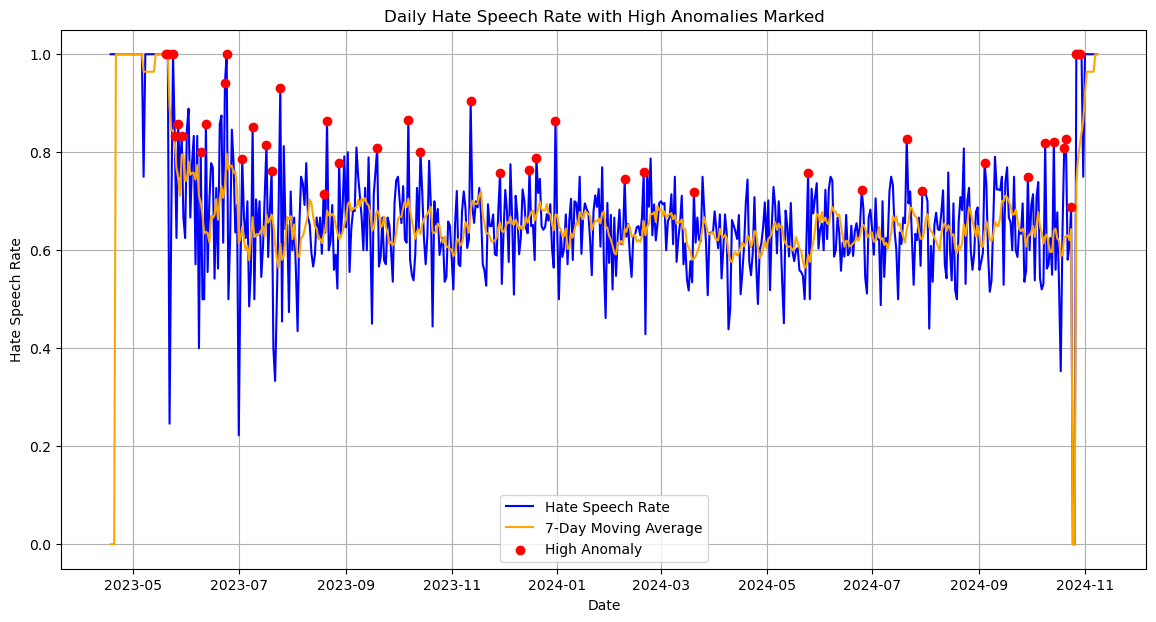

In [255]:
# Plot hate rate with anomalies marked only for high spikes
plt.figure(figsize=(14, 7))
plt.plot(daily_data['Date'], daily_data['hate_rate'], label='Hate Speech Rate', color='blue')
plt.plot(daily_data['Date'], daily_data['hate_rate_ma'], label='7-Day Moving Average', color='orange')

# Highlight high anomaly points in red
high_anomaly_dates = daily_data[daily_data['z_score_anomaly'] | daily_data['residual_anomaly'] | daily_data['chi_square_anomaly']]
plt.scatter(high_anomaly_dates['Date'], high_anomaly_dates['hate_rate'], color='red', label='High Anomaly', zorder=5)

plt.xlabel('Date')
plt.ylabel('Hate Speech Rate')
plt.title('Daily Hate Speech Rate with High Anomalies Marked')
plt.legend()
plt.grid(True)
plt.show()